In [1]:
import os
import json
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline 

In [36]:
import os
import subprocess

In [92]:
VIDEO_ROOT = "./video_subir_drive"

In [2]:
df = pd.read_json("salida_.json")

In [93]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [140]:
for index , row in df.iterrows():
    path_video = os.path.join(VIDEO_ROOT , row["video"])
    segments = list(map(lambda x : x['segment'], row['clips']))
    list_files = sorted(listdir_nohidden(path_video))
    for i , seg_range in enumerate(segments):
        new_folder = os.path.join(path_video,f"{i+1}")
        if os.path.exists(new_folder):
            subprocess.call(f"rm -rf {new_folder}", shell=True)
        filesToCopy_list = list_files[seg_range[0]-1:seg_range[1]]
        filesToCopy_str = " ".join([ path_video+'/'+name for name in filesToCopy_list])
        os.mkdir(new_folder)
        subprocess.call(f"cp {filesToCopy_str} {new_folder}",shell=True)

In [123]:
#with open("./resultado_chica/_centroides.txt" , "r") as file:
import csv
with open("./resultado_chica/_centroides.txt") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    centroides = []
    for line in csv_reader:
        centroides.append(line)

In [141]:
import ffmpeg
for name , centroid in list(zip(df.video,centroides)):
    os.mkdir(f"{VIDEO_ROOT}/{name}/clustering")
    for centroides_ in centroid:
        try:
            centroides_ = centroides_.strip()
            input_name = f'{VIDEO_ROOT}/{name}/{centroides_}/*.jpg'
            output_name = f'{VIDEO_ROOT}/{name}/{centroides_}/{centroides_}.mp4'
            (
                ffmpeg
                .input(input_name, pattern_type='glob')
                .output(output_name)
                .run()
            )
            subprocess.call(f"cp {output_name} {VIDEO_ROOT}/{name}/clustering/" ,shell=True)
        except:
            print(name)
            continue

test2_cam1_134.MP4
test2_cam1_139.MP4
test2_cam1_14.MP4
test2_cam1_6.MP4
test2_cam1_76.MP4
test2_cam1_78.MP4
test2_cam1_86.MP4
test2_cam2_114.MP4
test2_cam2_142.MP4
test2_cam2_168.MP4
test2_cam2_212.MP4
test2_cam2_220.MP4
test2_cam2_24.MP4
test2_cam2_39.MP4


In [147]:
os.mkdir("salida_fina")
for name in df.video:
  
        os.mkdir(f"salida_fina/{name}")
        subprocess.call(f"cp -av {VIDEO_ROOT}/{name}/clustering ./salida_fina/{name}",shell=True)
   

In [4]:

def clustering(dic_segment):
    list_fetures = list()
    for i in dic_segment:
        list_fetures.append(np.array(i["features"]))
    return np.array(list_fetures)

In [5]:
clustering_ = KMeans(n_clusters=3)

In [6]:
list_features = list()
for value in df.clips.apply(clustering):
    list_features.extend(value)

In [7]:
solution = clustering_.fit(np.array(list_features))

In [8]:
pd.Series(solution.labels_).value_counts()

0    15665
1    12083
2     6100
dtype: int64

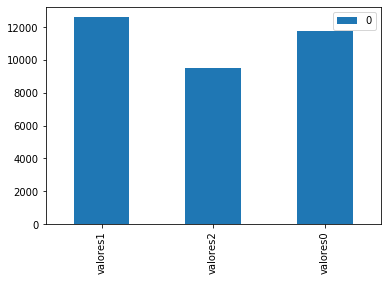

In [9]:
dict_valores = { "valores1" : [0] , "valores2" : [0] , "valores0" : [0]}
for value in df.clips.apply(clustering):
    try:
        for values_ in KMeans(n_clusters=3).fit(value).labels_:
            if values_ == 1 :
                dict_valores["valores1"][0] += 1
            elif values_ == 2:
                dict_valores["valores2"][0] += 1
            else :
                dict_valores["valores0"][0] += 1 
    except :
        continue
pd.DataFrame(dict_valores).transpose().plot.bar()

In [29]:


def draw_cycle_using(name_file, x, y, scale = 2):
    fig = plt.figure()
    axes = fig.add_subplot(111)
    # my random data
    # spacing of arrows
    aspace = .1 # good value for scale of 1
    aspace *= scale
    if isinstance(x , list):
        x = np.array(x)
    if isinstance(y , list):
        y = np.array(y)

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = 0 # current point on walk along data
    rcount = 1 
    while arrowPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit
        axes.arrow(ax,ay,
                np.sin(theta)*aspace/10,np.cos(theta)*aspace/10, 
                head_width=aspace/8)
    if y[0] == 0 :
        axes.plot(x,y,'b')
    elif y[0] == 1 :
        axes.plot(x,y,'g')
    else:
        axes.plot(x,y,'r')
    axes.set_xlim(0,x.max()*1.1)
    axes.set_ylim(0,2.5)
    plt.savefig(f"figuras/{name_file[:-4]}.png")
    plt.clf()

In [24]:
with open("entrada" ,"r") as file:
    video_names = file.read().split('\n')

In [98]:
with open("_resultado_chica_centroids_test.txt" , "a") as file:
    for name ,value_ in zip(video_names, df.clips.apply(clustering)):
        try:
            model = KMeans(n_clusters= 3).fit(value_)
            indexs = get_index(model, value_)
            #draw_cycle_using(name,list(range(0 , len(x))) ,x )
            #min_dist = np.min(cdist(.as_matrix(), model.cluster_centers_, 'euclidean'), axis=1)

            file.writelines(f"Video {name} centroides = {indexs} \n")
            #file.writelines
            #print(x)
        except:
            file.writelines(f"Video en indice {name} es muy corto \n")
            
            

In [44]:
model = KMeans(n_clusters= 3)
model_values = model.fit_predict(df.clips.apply(clustering)[0])
            

In [45]:
min_dist = np.min(cdist(df.clips.apply(clustering)[0], model.cluster_centers_, 'euclidean'), axis=1)

In [46]:
from scipy.spatial.distance import cdist


In [97]:
def get_index(model , clips):
    centroides_index = []
    for cluster_value in model.cluster_centers_:
        pos = 0
        min_ = 9999
        for i, value in enumerate(clips):
            value_ = np.sqrt(np.sum((value - cluster_value) ** 2))
            if value_ < min_ :
                pos = i
                min_ = value_
        centroides_index.append(pos)
    return sorted(centroides_index)


In [79]:
i

61

In [69]:
for i, value in enumerate(df.clips.apply(clustering)[0]):
    for cluster_value in model.cluster_centers_:
        print(np.sqrt(np.sum((value - cluster_value) ** 2)))
        break
    break

5.33500526382956
